In [1]:
import sys
print(sys.executable)

c:\Users\nil\Desktop\TFGv2\.venv\Scripts\python.exe


Data visualization 

In [2]:
import json
import pandas as pd
from pathlib import Path

# Load raw and processed files
raw_path = Path("data/raw/sql-llama-instruct-v0.5.jsonl")
processed_path = Path("data/processed/sql-llama-instruct-v0.5.jsonl")

def load_jsonl(path):
    with open(path, 'r', encoding='utf-8') as f:
        return [json.loads(line) for line in f]

raw_data = load_jsonl(raw_path)
processed_data = load_jsonl(processed_path)

print(f"Loaded {len(raw_data)} raw examples")
print(f"Loaded {len(processed_data)} processed examples")


Loaded 3375 raw examples
Loaded 3375 processed examples


In [3]:
#Extract flattened records for inspection
flattened_data = []
for entry in raw_data:
    record = {
        "system": next((m['content'] for m in entry['messages'] if m['role'] == 'system'), None),
        "user": next((m['content'] for m in entry['messages'] if m['role'] == 'user'), None),
        "assistant": next((m['content'] for m in entry['messages'] if m['role'] == 'assistant'), None),
    }
    flattened_data.append(record)

# Create DataFrame
df_flat = pd.DataFrame(flattened_data)

# Show the first few entries
df_flat.head()

,system,user,assistant
0,,As an experienced and professional database ad...,"\n```json\n{\n ""lists"": ""drop_all"",\n ""movie..."
1,,"Given a 【Database schema】 description, a knowl...",\nSub question 1: What is the most popular mov...
2,,As an experienced and professional database ad...,"\n```json\n{\n ""lists"": ""drop_all"",\n ""movie..."
3,,"Given a 【Database schema】 description, a knowl...",\nSub question 1: Retrieve the popularity for ...
4,,As an experienced and professional database ad...,"\n```json\n{\n ""lists"": ""drop_all"",\n ""movie..."


In [30]:
# count the instance on user column that start with Given... (this will be the decomposer) and the columns that start by As... (this will be the selctor)
decomposer_count = df_flat['user'].str.startswith('Given').sum()
selector_count = df_flat['user'].str.startswith('As').sum()
print(f"Decomposer count: {decomposer_count}")
print(f"Selector count: {selector_count}")
# TOTAL count
total_len = len(df_flat)
refiner_count = total_len - (decomposer_count + selector_count)
print(f"Refiner count: {refiner_count}")

Decomposer count: 2029
Selector count: 1009
Refiner count: 337


In [ ]:
# how many start by [instruction] the refiner count is correct
instruction_count = df_flat['user'].str.startswith('【').sum()
print(f"Instruction count: {instruction_count}")

Instruction count: 337


Visualization for task 

In [ ]:
#import sys
#!{sys.executable} -m pip install matplotlib seaborn



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


C:\Users\nil\AppData\Local\Temp\ipykernel_13980\322051523.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=task_types, y=counts, palette=['blue', 'orange', 'green'])


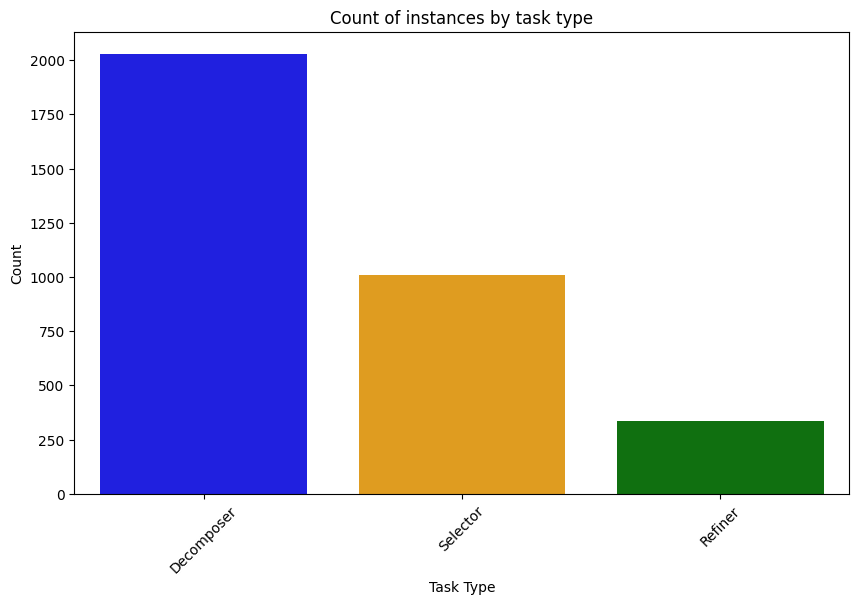

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

counts = [decomposer_count, selector_count, refiner_count]  # Refiner count is 0
task_types = ['Decomposer', 'Selector', 'Refiner']

plt.figure(figsize=(10, 6))
sns.barplot(x=task_types, y=counts, palette=['blue', 'orange', 'green'])
plt.title('Count of instances by task type')
plt.xlabel('Task Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

- Difference in instances depending on complexity
- Class imbalance

We observed a class imbalance across the three fine-tuning tasks. The dataset is heavily skewed toward Decomposer instances (~2,000), followed by Selector (~1,000), and significantly fewer Refiner cases (~300). This imbalance is likely to cause the model to underperform on underrepresented tasks unless compensated through sampling, weighted loss, or task-specific adaptation strategies.

| Hypothesis                                           | Strategy                                                                               |
| ---------------------------------------------------- | -------------------------------------------------------------------------------------- |
| Refiner might underperform due to low representation | Consider **oversampling**, **augmentation**, or **loss weighting**                     |
| Decomposer dominates — could bias generalization     | Compare baseline vs. **balanced training** using `class weights` or stratified batches |
| Selector likely benefits from more schema diversity  | Try **data augmentation**: change schema/table names or column orders                  |


Cleaning 

In [7]:
# Check for duplicate column names
duplicates = df_flat.columns[df_flat.columns.duplicated()]

if len(duplicates) > 0:
    print("Duplicate columns found:", duplicates.tolist())
else:
    print("No duplicate columns found.")

No duplicate columns found.


In [8]:
# are there nans in the columns?
nan_columns = df_flat.columns[df_flat.isna().any()].tolist()
if len(nan_columns) > 0:
    print("Columns with NaN values:", nan_columns)
else:
    print("No NaN values found in any columns.")

No NaN values found in any columns.


Let's see if there are some anomalies

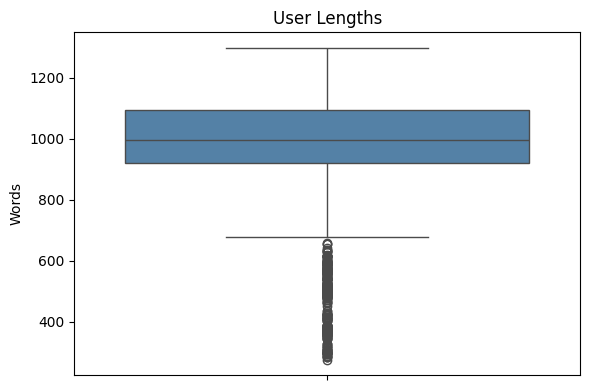

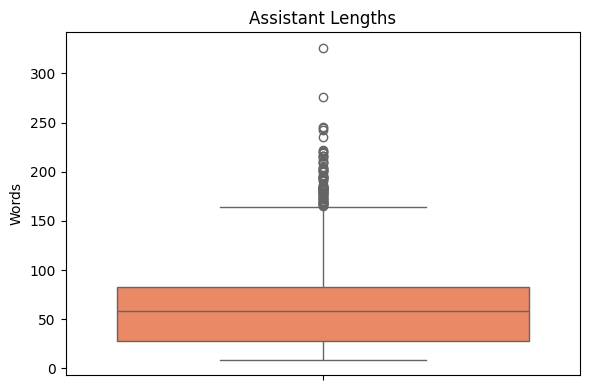

In [12]:
df_analysis = df_flat.copy()

# Number of words in the user question and assistant SQL
df_analysis['user_len'] = df_analysis['user'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
df_analysis['assistant_len'] = df_analysis['assistant'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

# Boxplot for user question lengths
plt.figure(figsize=(6, 4))
sns.boxplot(y=df_analysis['user_len'], color='steelblue')
plt.title('User Lengths')
plt.ylabel('Words')
plt.tight_layout()
plt.show()

# Boxplot for SQL query lengths
plt.figure(figsize=(6, 4))
sns.boxplot(y=df_analysis['assistant_len'], color='coral')
plt.title('Assistant Lengths')
plt.ylabel('Words')
plt.tight_layout()
plt.show()




In [28]:
# oreder user messages by their length
df_analysis['user_len'] = df_analysis['user'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
df_analysis = df_analysis.sort_values(by='user_len', ascending=True)
# print head
df_analysis.head(10)[['user', 'user_len']]

,user,user_len
1428,"【Instruction】\nWhen executing SQL below, some ...",277
1402,"【Instruction】\nWhen executing SQL below, some ...",286
1403,"【Instruction】\nWhen executing SQL below, some ...",286
1401,"【Instruction】\nWhen executing SQL below, some ...",286
2222,"【Instruction】\nWhen executing SQL below, some ...",290
2221,"【Instruction】\nWhen executing SQL below, some ...",290
2220,"【Instruction】\nWhen executing SQL below, some ...",296
2229,"【Instruction】\nWhen executing SQL below, some ...",296
2228,"【Instruction】\nWhen executing SQL below, some ...",296
2224,"【Instruction】\nWhen executing SQL below, some ...",298


In [26]:
# oreder user messages by their length
df_analysis['assistant_len'] = df_analysis['assistant'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
df_analysis = df_analysis.sort_values(by='assistant_len', ascending=True)
# print head
df_analysis.head(10)[['assistant', 'assistant_len']]

,assistant,assistant_len
1502,"\n```json\n{\n ""playstore"": ""drop_all"",\n ""u...",9
2896,\n```sql\nSELECT id\nFROM sport\nWHERE sport_n...,10
1064,\n```sql\nSELECT gender FROM gender_age WHERE ...,10
2897,\n```sql\nSELECT id FROM sport WHERE sport_nam...,10
1063,\n```sql\nSELECT gender\nFROM gender_age_train...,10
2738,\n```sql\nSELECT COUNT(`voice-actor`) FROM `vo...,10
2737,\n```sql\nSELECT COUNT(voice_actor) FROM `voic...,10
2736,\n```sql\nSELECT COUNT(voice_actor) FROM voice...,10
632,"\n```json\n{\n ""location"": ""drop_all"",\n ""us...",11
2079,\n```sql\nSELECT COUNT(DISTINCT game.id) FROM ...,11
